In [227]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

Define Functions

In [228]:
def isSegment(p1,p2, bin_im, ksize, sample_num, pvote, cvote):
    x1, y1 = p1
    x2, y2 = p2
    
    x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
    
    x_disp = x2- x1
    y_disp = y2- y1
    
    x_step = x_disp // (sample_num + 1)
    y_step = y_disp // (sample_num + 1)
    
    vote = 0

    for mult in range(1, sample_num + 1):  
        xc, yc = x1 + mult*x_step, y1 + mult*y_step
        view = bin_im[xc - ksize: xc + ksize, yc - ksize: yc + ksize]
         
        color = (0,255,0)
        if np.sum(view) >= pvote:
            vote += 1 
            color = (0,0,255)
        print("OUTPUT" + str(np.sum(view)) + " " + str(pvote))
        cv2.circle(im_display, (int(xc), int(yc)), 6, color, thickness=1, lineType=8, shift=0) 

#     print("OUTPUT",vote, cvote)
    return vote >= cvote

SyntaxError: invalid syntax (<ipython-input-228-394e450ac86c>, line 23)

In [195]:
def getCorners(img):   
    gray = np.float32(img)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    
    return corners

In [196]:
def getSegments(img, corners, ksize, sample_num, pvote, cvote):
    segments = []

    for i in range(len(corners)):
        for j in range(i + 1, len(corners)):
            c1, c2 = corners[i], corners[j]
            if isSegment(c1, c2, img, ksize, sample_num, pvote, cvote):
                segments.append((tuple(c1), tuple(c2)))
    
            break
        
        break
        
    return segments


## Test Functions

##### hyperparameters

In [215]:
KSIZE = 2
PVOTE = 3
CVOTE = 3
SAMPLE_NUM = 15

img_directory = "images/"

##### test script

12561


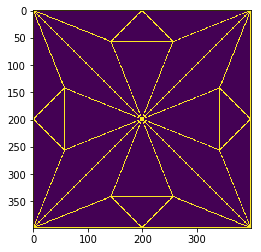

In [218]:
im = cv2.imread(img_directory + "frog.png")
im_display = np.zeros(im.shape, dtype = np.uint8)
im_display.fill(255)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# "Preps Image to be displayed" - Lillian

im = np.invert(im)

im[im > 10] = 1
im[im != 1] = 0
plt.imshow(im)

print(np.sum(im))


In [217]:

cv2.imwrite(img_directory + "frogcorners.png", im)

corners = getCorners(im)
segments = getSegments(im, corners, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)


# print("DETECTED SEGMENTS")
# for i in segments:
#     cv2.line(im_display, i[0], i[1], (0,0,255),1) 

# # cv2.line(im_display, segments[1][0], segments[1][1], (0,255,0), 3)

# cv2.line(im_display, segments[1][0], segments[1][1], (0,255,0), 3)

    # print("("+ str(i) +","+str(segments.get(i))+")")

# cv2.circle(im_display, (int(196.46725), int(197.349)), 2, (0,255,0), thickness=1, lineType=8, shift=0) 

test = isSegment((1.6140463, 199.0812),(196.46725, 197.349 ), im, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)
#print test

cv2.imwrite(img_directory + "cornersdisplay" + str(KSIZE) +  str(PVOTE) + str(CVOTE) + str(SAMPLE_NUM) + ".png", im_display)


OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT10 3
OUTPUT4 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT0 3
OUTPUT2 3
OUTPUT3 3


True